In [237]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchmin import minimize_constr

In [238]:
N_skin = 600
N_bandage = 400

In [239]:
connected_points = torch.Tensor([87, 53, 32, 31]).type(torch.int64)

In [240]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[ 0.0098, -0.0097,  0.0035]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control

# Straight up peeling control
# spline_control = np.array([[ 0.0038, -0.0097,  0.0065],
#                            [ -0.0038, -0.0097,  0.0085],
#                            [ -0.0078, -0.0097,  0.0115]])
spline_control = np.array([[ 0.0098, -0.0037,  0.0065],
                           [ 0.0098, 0.0037,  0.0085],
                           [ 0.0098, 0.0077,  0.0115]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [241]:
contact_sur_0 = torch.tensor([600, 601, 602, 603, 604, 606, 607, 608, 609, 616, 617, 618, 619, 620,
         621, 622, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 644,
         645, 647, 648, 650, 651, 652, 667, 668, 669, 670, 671, 672, 673, 674,
         675, 676, 678, 679, 692, 693, 694, 695, 696, 697, 706, 707, 708, 709,
         710, 711, 712, 713, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728,
         729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742,
         743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756,
         757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770,
         771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784,
         785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798,
         799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812,
         813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826,
         827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840,
         841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854,
         855, 856, 857, 858, 859, 860, 861]) - 600

In [242]:
contact_sur_1 = torch.tensor([ 43,  50,  51,  54,  60,  61,  92, 103, 104, 106, 108, 110, 117, 154,
         158, 164, 165, 166, 168, 170, 176, 197, 198, 219, 220, 223, 228, 229,
         230, 235, 238, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
         429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
         443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
         457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
         471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
         485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498,
         499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
         513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,
         527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540,
         541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
         555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
         569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
         583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
         597, 598, 599])

In [243]:
control_point = 43

In [244]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.004), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.003), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([0, 1])
softbody.add_multi_boundary_constrain(1, 0, 0.0017, contact_sur_0, contact_sur_1)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, -0.001, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.003, 2)
# softbody.fix_larger_than(0, 0.0018, 2)

detect 2 object


In [245]:
softbody.V_list[1][control_point]

tensor([ 0.0098, -0.0097,  0.0035], dtype=torch.float64)

In [246]:
norm_vec = np.array([-1, 1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


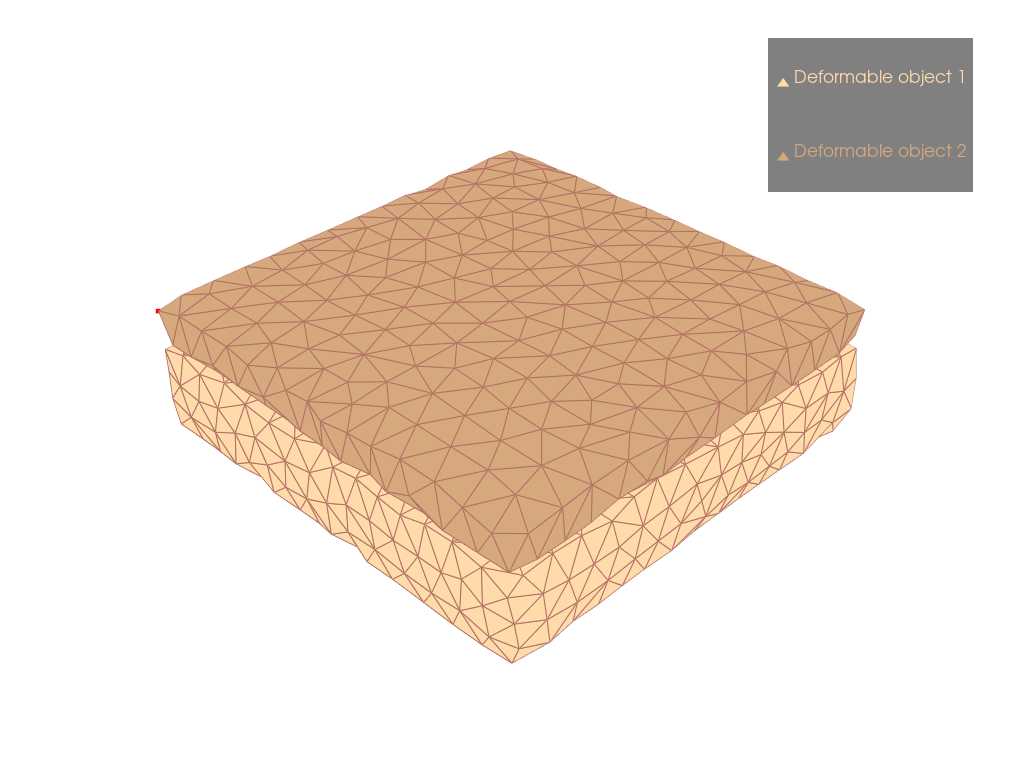

In [247]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + control_point].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [248]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [249]:
softbody.C_boundary_list[0].shape

torch.Size([849, 2])

In [250]:
# color = np.zeros(400)
# color[306] = 1

In [251]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [252]:
stiffness_norm = -np.array([1, 1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur_0.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur_0[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
        stiffness_color.append(energy_max)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [253]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


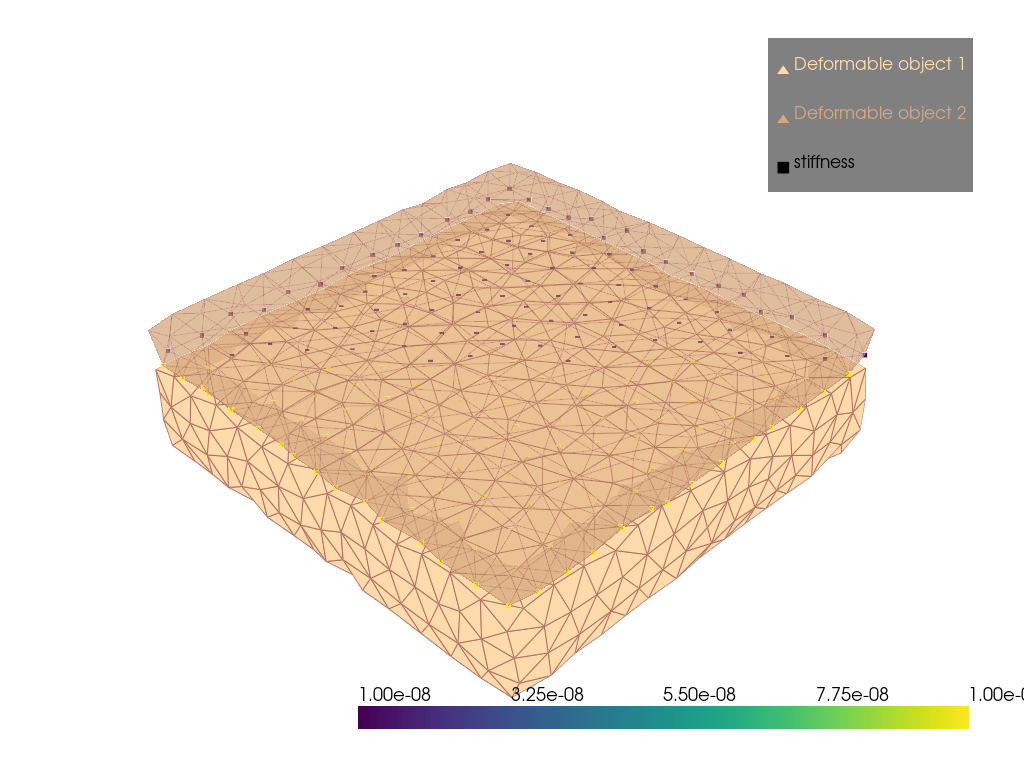

In [254]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur_0].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [255]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [256]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


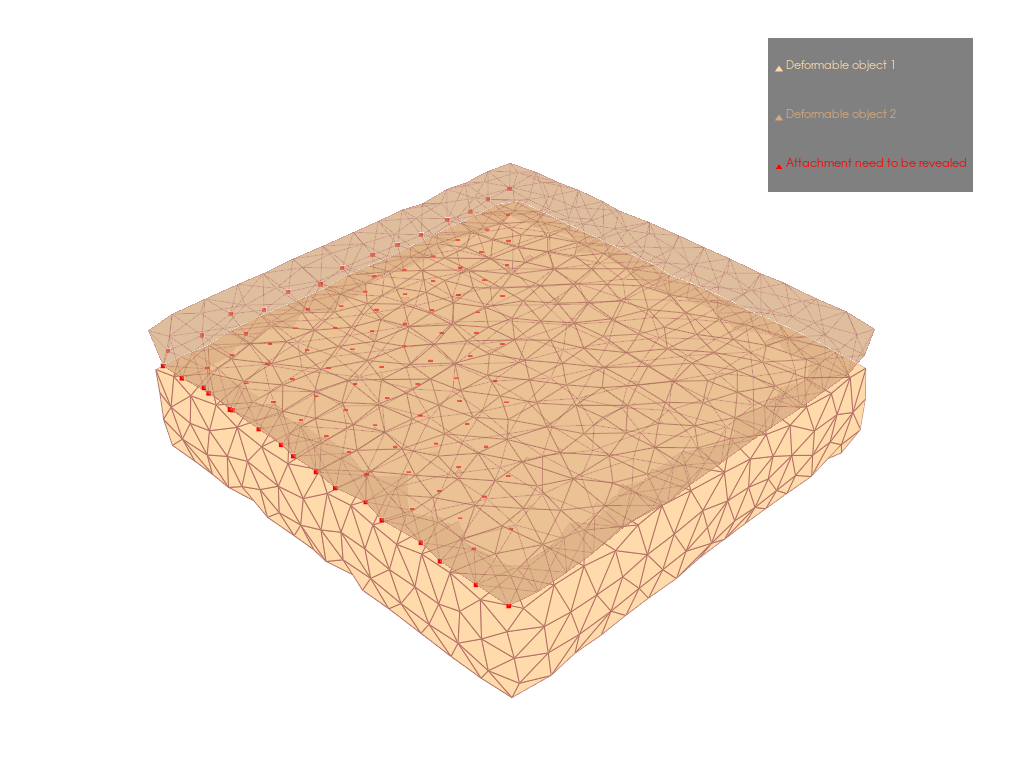

In [257]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [258]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 10
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [259]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0023])

In [260]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[ 0.0098, -0.0037,  0.0065],
        [ 0.0098,  0.0037,  0.0085],
        [ 0.0098,  0.0077,  0.0115]], dtype=torch.float64, requires_grad=True)

In [261]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [262]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
    return torch.norm(target - predict) / 100 + penalty * alpha + energy * 5e5
# def loss_fn(predict, target, penalty, energy, alpha=1e6, beta=1):
#     return energy

In [263]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [264]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0040])

In [265]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([849, 2])

In [266]:
spline_list = []

In [267]:
def force(connect, control):
    return torch.norm(softbody.V[softbody.offset_list[1] + control] - softbody.V[softbody.offset_list[1] + connect])**2

start simulation


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:07<00:00,  5.33it/s]


loss: tensor([5.3395], grad_fn=<AddBackward0>)
Accuracy: tensor(0.6825) tensor(0.9016)
avg energy: tensor([7.8931e-06], grad_fn=<DivBackward0>)
constrain tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)
None


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


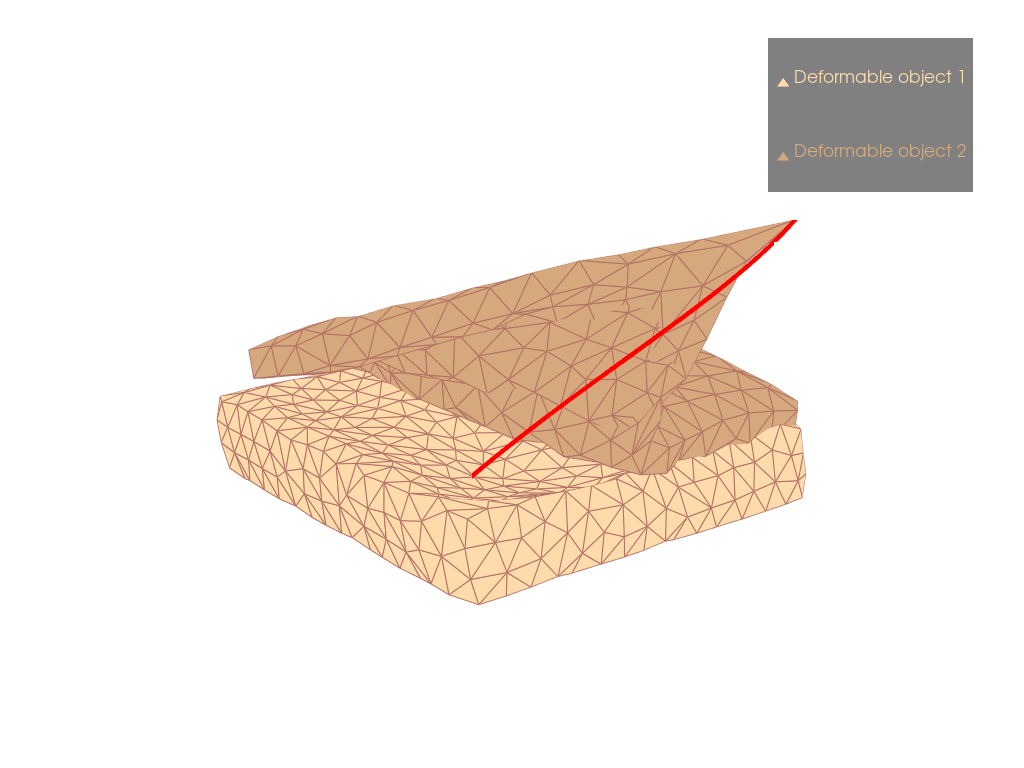

In [268]:
# get cubic bezier spline control after step
x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
spline_x = spline[0]
spline_y = spline[1]
spline_z = spline[2]
spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
# print(spline_trajectory)
# restore original vertex and velocity
softbody.V = V_origin.clone()
softbody.V_velocity = V_velocity_origin.clone()

# restore stiffness
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 10
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.001
V_shape_stiffness[:600] = 0.001
V_shape_stiffness[600:] = 0.000001
V_dist_stiffness[:600] = 1
V_dist_stiffness[600:] = 0.1
print('start simulation')
energy_total = torch.zeros(1)
energy_list = []
force_list = []
for i in trange(spline_trajectory.shape[0]):
# for i in range(1):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
    energy_total += torch.sum(energy)
    energy_list.append(torch.sum(energy).detach().cpu().numpy())
    force_list.append(force(connected_points, control_point).detach().cpu().numpy())
    # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
    # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
    skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

# loss = torch.norm(V_boundary_stiffness)
energy_avg = energy_total / spline_trajectory.shape[0]
constrain = torch.sigmoid(1e8 * (start_point[:, 2] - spline_trajectory[1:, 2]))
constrain = torch.sum(constrain)
TT_score, NN_score = eval(V_boundary_stiffness, boundary_mask)
loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, energy_avg, alpha=0, beta=TT_score)

print('loss:', loss)
print('Accuracy:', TT_score, NN_score)
print('avg energy:', energy_avg)
print('constrain', constrain)
print(spline_control.grad)
spline_list.append(spline_trajectory)
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = [(0.04943279151406822, -0.03977536222547223, 0.021820325700180415),
(7.301401243626354e-06, 2.0879731106636726e-05, 0.003000000142492353),
(-0.23015530645193596, 0.1675075959527941, 0.95862909418092)]
pl.show()
    

# pl.close()

In [269]:
# energy_0 = energy_list.copy()

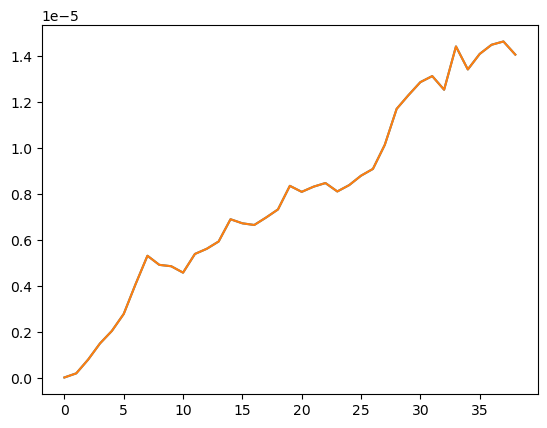

In [270]:
plt.plot(energy_0)
plt.plot(energy_list)

In [271]:
# force_0 = force_list.copy()

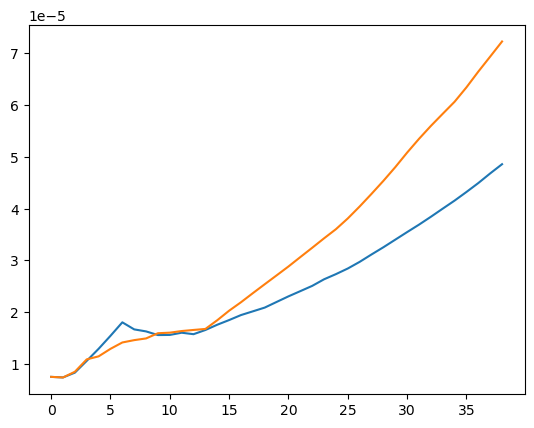

In [274]:
plt.plot(force_list)
plt.plot(force_0)